## Imports

In [104]:
import numpy as np
import matplotlib.pyplot as plt

## Defining the function $U(N_{j,t},t)$

In [105]:
def f(t):
  return np.log(1+t*(np.log(t)**2))

## Implementation of two variants of UCB

### 1. Standard UCB 

In [106]:
def UCB(K,N,mu):

    # optimal arm
    opt_arm = np.argmax(mu)
    opt_value = np.max(mu)
    # gaps
    gaps = opt_value - mu

    # variables
    arm_samples_hist = np.zeros((N, K))
    mu_est = np.zeros(K)
    n_pulls = np.zeros(K)
    U = np.zeros(K)
    regret_per_step = np.zeros(N)

    ### execution

    # initialization phase
    for t in range(K):
      # select arm in a round robin fashion
      arm_to_pull = t

      # pull the arm and observe a random reward
      sample =bernouilli( mu[arm_to_pull])

      # update logs
      arm_samples_hist[n_pulls[arm_to_pull].astype(int), arm_to_pull] = sample
      n_pulls[arm_to_pull] = n_pulls[arm_to_pull] + 1
      regret_per_step[t] = gaps[arm_to_pull]

    # initialize algorithm's uncertainity
    mu_est = np.sum(arm_samples_hist, 0) / n_pulls
    U = np.sqrt(f(K)/(2*n_pulls))


    # learning phase
    for t in range(K, N):
      # select the arm with the largest ucb index
      arm_to_pull = np.argmax(mu_est+U)
      # pull the arm and observe a random reward
      sample = np.random.binomial(1, mu[arm_to_pull])

      # update 
      arm_samples_hist[n_pulls[arm_to_pull].astype(int), arm_to_pull] = sample
      n_pulls[ arm_to_pull] = n_pulls[arm_to_pull] + 1
      mu_est = np.sum(arm_samples_hist, 0) / n_pulls
      U = np.sqrt(f(t+1)/(2*n_pulls))
      regret_per_step[t] = gaps[arm_to_pull]

      
    regret = np.sum(regret_per_step)
    return regret


In [107]:
UCB(2,1000,[0.5,0.7])

4.799999999999999

### 2.  KL-UCB

In [108]:
def d_kl(p,q): #the KL divergence for Bernouilli
  if (p==0) or(p==1):
    return 0
  if (q==0) or(q==1):
    return np.inf
  return p*np.log(p/q)+(1-p)*np.log((1-p)/(1-q))

In [109]:
def inner_max(p,bound, nbr_points=int(10),epsilon =1e-1):
  #this functions finds max{q |d_kl(p,q) <= bound} 
  a = p
  b = 1 
  c=(a+b)/2
  iter=0
  while (abs(b-d_kl(p,c)) > epsilon) and (iter <20):
    iter +=1
    if b>d_kl(p,c):
      a= c
    else :
      b=c
    c=(a+b)/2
  return c

In [110]:
def inner_max_vec(P,Bound,nbr_points=int(10)):
  # this function is the vector version of the previous function 
  result = []
  for i in range(len(P)):
    result.append(inner_max(P[i],Bound[i],nbr_points))
  return result

In [116]:
def KL_UCB(K,N,mu):

    # optimal arm
    opt_arm = np.argmax(mu)
    opt_value = np.max(mu)
    # gaps
    gaps = opt_value - mu

    # variables
    arm_samples_hist = np.zeros((N, K))
    mu_est = np.zeros(K)
    n_pulls = np.zeros(K)
    U = np.zeros(K)
    regret_per_step = np.zeros(N)

    ### execution

    # initialization phase
    for t in range(K):
      # select arm in a round robin fashion
      arm_to_pull = t

      # pull the arm and observe a random reward
      sample =np.random.binomial( 1,mu[arm_to_pull])

      # update logs
      arm_samples_hist[n_pulls[arm_to_pull].astype(int), arm_to_pull] = sample
      n_pulls[arm_to_pull] += 1
      regret_per_step[t] = gaps[arm_to_pull]

    # initialize algorithm's uncertainity
    mu_est = np.sum(arm_samples_hist, 0) / n_pulls
    U = inner_max_vec(mu_est,f(K)/n_pulls)
    

    # learning phase
    for t in range(K, N):
      # select the arm with the largest ucb index
      arm_to_pull = np.argmax(U)
      # pull the arm and observe a random reward
      sample = np.random.binomial(1, mu[arm_to_pull])

      # update 
      arm_samples_hist[n_pulls[arm_to_pull].astype(int), arm_to_pull] = sample
      n_pulls[ arm_to_pull] = n_pulls[arm_to_pull] + 1
      mu_est = np.sum(arm_samples_hist, 0) / n_pulls
      U = inner_max_vec(mu_est ,f(t+1)/n_pulls)
      regret_per_step[t] = gaps[arm_to_pull]

      
    regret = np.sum(regret_per_step)
    return regret


# Case of $K=2$ and $(\mu_1 , \mu_2) = (0.5 , 0.5 + \Delta)$ :

In [117]:
def UCB_2(mu1,delta,nbr_exec=100):
  #this function computes the expected regret of the ucb by averaging over many executions
  expected_regret = 0

  for i in range(nbr_exec):
    expected_regret += UCB(2,1000,[mu1,mu1+delta])

  expected_regret = expected_regret/nbr_exec

  return expected_regret

In [114]:
def UCB_kl_2(mu1,delta,nbr_exec=100):
  #this function computes the expected regret of the ucb by averaging over many executions
  expected_regret = 0

  for i in range(nbr_exec):
    expected_regret += KL_UCB(2,1000,[mu1,mu1+delta])

  expected_regret = expected_regret/nbr_exec

  return expected_regret

###Plotting th expected regret

In [124]:
delta_range1=np.linspace(-0.45,0.45,100)
ucb_range1 =[]
ucb_kl_range1 = []
for delta in delta_range1:
  ucb_range1.append(UCB_2(0.5,delta))
  ucb_kl_range1.append(UCB_kl_2(0.5,delta))

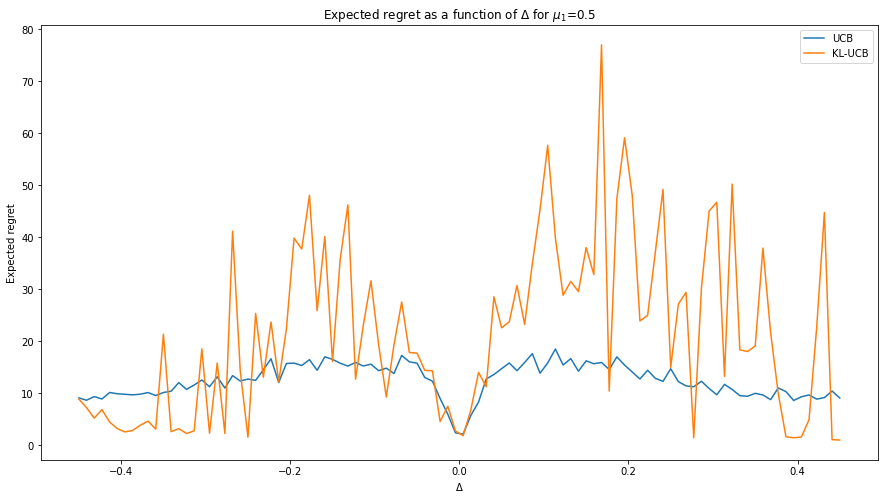

In [126]:
plt.figure(figsize=(15,8))
plt.plot(delta_range1,ucb_range1,label="UCB")
plt.plot(delta_range1,ucb_kl_range1,label="KL-UCB")
plt.xlabel("$\Delta$")
plt.ylabel("Expected regret")
plt.legend()
plt.title("Expected regret as a function of $\Delta$ for $\mu_1$=0.5")
plt.show()

# Case of $K=2$ and $(\mu_1 , \mu_2) = (0.9, 0.9+\Delta)$ :

In [127]:
delta_range2=np.linspace(-0.85,0.05,100)
ucb_range2 =[]
ucb_kl_range2= []
for delta in delta_range2:
  ucb_range2.append(UCB_2(0.9,delta))
  ucb_kl_range2.append(UCB_kl_2(0.9,delta))

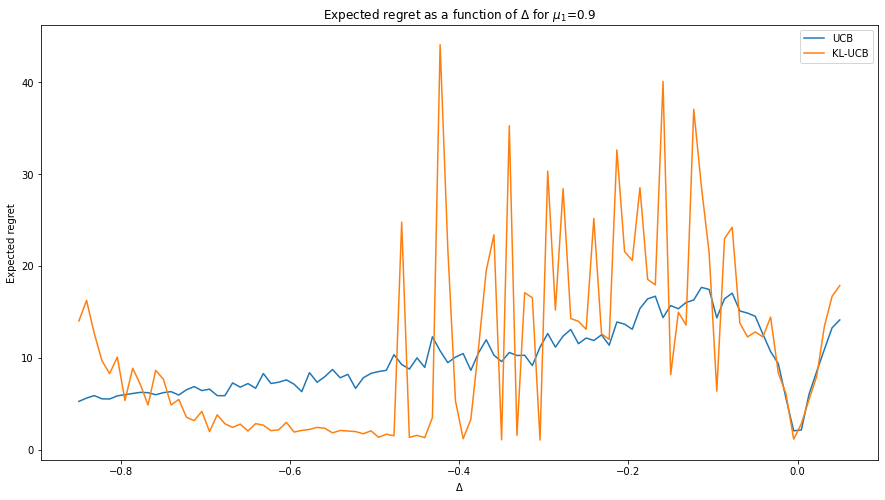

In [128]:
plt.figure(figsize=(15,8))
plt.plot(delta_range2,ucb_range2,label="UCB")
plt.plot(delta_range2,ucb_kl_range2,label="KL-UCB")
plt.xlabel("$\Delta$")
plt.ylabel("Expected regret")
plt.legend()
plt.title("Expected regret as a function of $\Delta$ for $\mu_1$=0.9")
plt.show()

# Case of $K=2$ and $(\mu_1 , \mu_2) = (0.1, 0.1+\Delta)$ :

In [131]:
delta_range3=np.linspace(-0.05,0.85,100)
ucb_range3 =[]
ucb_kl_range3 = []
for delta in delta_range3:
  ucb_range3.append(UCB_2(0.1,delta))
  ucb_kl_range3.append(UCB_kl_2(0.1,delta))

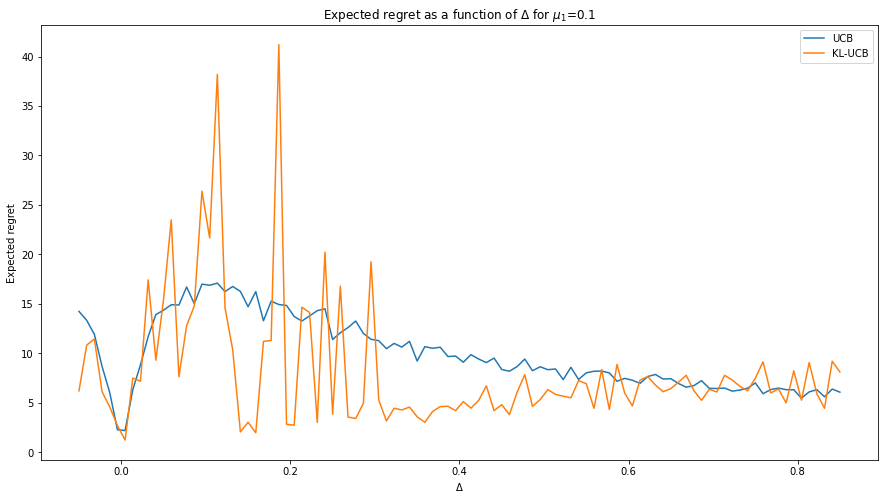

In [132]:
plt.figure(figsize=(15,8))
plt.plot(delta_range3,ucb_range3,label="UCB")
plt.plot(delta_range3,ucb_kl_range3,label="KL-UCB")
plt.xlabel("$\Delta$")
plt.ylabel("Expected regret")
plt.legend()
plt.title("Expected regret as a function of $\Delta$ for $\mu_1$=0.1")
plt.show()